# Storage operation disaggregator

A module to disaggregate energy storage operation by time scales.
The disaggregation only requires the charging and discharging power profiles and is agnostic with respect to electricity prices or other drivers.


## Installation

```bash
pip install storedisagg
```



## Example

In [ ]:
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

import storedisagg as std

%matplotlib inline

## Retrieve example data
Example data with 100 time slots is generated in the storedisagg.example.example_data module.

,echg,edch,mc,Discharging,Charging
sy,,,,,
0.0,0.000000,-0.0,0.0,0.0,0.000000
1.0,0.123760,-0.0,0.0,0.0,0.123760
2.0,0.227968,-0.0,0.0,0.0,0.227968
3.0,0.352666,-0.0,0.0,0.0,0.352666
4.0,0.458185,-0.0,0.0,0.0,0.458185
5.0,0.499873,-0.0,0.0,0.0,0.499873
6.0,0.457757,-0.0,0.0,0.0,0.457757


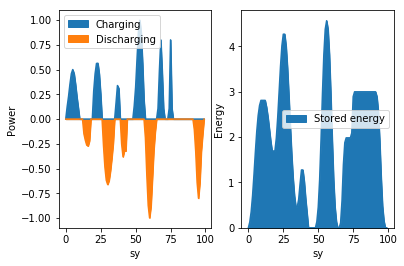

In [3]:
df = std.get_example_data_100()

fig, ax = plt.subplots(1, 2)

dfplot = df.set_index('t').assign(Discharging=-df['dch'], Charging=df['chg'])
display(dfplot.head(7))

dfplot['Stored energy'] = dfplot[['Charging', 'Discharging']].sum(axis=1).cumsum()

dfplot[['Charging', 'Discharging']].plot.area(ax=ax[0])
dfplot[['Stored energy']].plot.area(ax=ax[1])
for iax, ylab in enumerate(['Power', 'Energy']): ax[iax].set_ylabel(ylab)

## Run disaggregation for all component profile assignment kinds

Here we loop over all component profile assignment kinds, instantiate the StDisaggregator class and call the main run() method. The printed differences shown in the output serve to compare the total profiles with the disaggregated ones and should be zero.

In [5]:
df_full_all = pd.DataFrame()
df_step_evts_all = pd.DataFrame()

for kind in ['share', 'leftright', 'rightleft', 'top', 'bottom']:

    tvd = std.StDisaggregator(df, 1, kind)
    tvd.run()

    df_full_all = pd.concat([df_full_all, tvd.df_full_stacked.assign(kind=kind)], axis=0)
    df_step_evts_all = pd.concat([df_step_evts_all, tvd.df_step_evts.assign(kind=kind)], axis=0)


100%|██████████| 6/6 [00:00<00:00, 52.02it/s]

Difference idch (events - total): 0.0
Difference ichg (events - total): 1.7763568394e-15
Net value input: 0.0
Net value disagg: 0.0
Difference net value: 0.0



100%|██████████| 6/6 [00:00<00:00, 31.55it/s]

Difference idch (events - total): 0.0
Difference ichg (events - total): 1.7763568394e-15
Net value input: 0.0
Net value disagg: 0.0
Difference net value: 0.0



 67%|██████▋   | 4/6 [00:00<00:00, 32.61it/s]

Difference idch (events - total): 0.0
Difference ichg (events - total): 1.7763568394e-15


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]


Net value input: 0.0
Net value disagg: 0.0
Difference net value: 0.0


100%|██████████| 6/6 [00:00<00:00, 47.40it/s]

Difference idch (events - total): 0.0
Difference ichg (events - total): 1.7763568394e-15
Net value input: 0.0
Net value disagg: 0.0
Difference net value: 0.0



 83%|████████▎ | 5/6 [00:00<00:00, 35.69it/s]

Difference idch (events - total): 0.0
Difference ichg (events - total): 1.7763568394e-15


100%|██████████| 6/6 [00:00<00:00, 28.31it/s]

Net value input: 0.0
Net value disagg: 0.0
Difference net value: 0.0


## Result dataframes

The result tables are:

### df_full_all (std.StDisaggregator.df_full)
containing the profiles of the components (nevent). It is indexed by nevents (=components) and time slot. Each nevent corresponds to a well-defined iteration.

* **echg/edch** are external charging and discharging, i.e. including losses; note that these are the original profiles, copied to each iteration
* **ichg/idch** are the temporal derivatives of the storage energy content

To obtain the external component charging and discharging profiles we need to adjust for the round trip losses.

In [6]:
display(df_full_all.set_index(['kind', 'iteration', 'nevent', 't']).head(10))

echg  edch       erg   mc  sy_orig  slot_min  \
kind  iteration nevent slot                                                     
share 0         1.0    0     0.000000  -0.0  0.000000  0.0      0.0         0   
      1         6.0    0     0.000000  -0.0  0.000000  0.0      0.0         0   
      0         1.0    1     0.123760  -0.0  0.123760  0.0      1.0         1   
      1         6.0    1     0.123760  -0.0  0.123760  0.0      1.0         1   
      0         1.0    2     0.227968  -0.0  0.351727  0.0      2.0         2   
      1         6.0    2     0.227968  -0.0  0.351727  0.0      2.0         2   
      0         1.0    3     0.352666  -0.0  0.704394  0.0      3.0         3   
      1         6.0    3     0.352666  -0.0  0.704394  0.0      3.0         3   
      0         1.0    4     0.458185  -0.0  1.162579  0.0      4.0         4   
      1         6.0    4     0.458185  -0.0  1.162579  0.0      4.0         4   

                             slot_max  ichg_all  idch_all      ichg  idch  
kind  iteration nevent slot                                                
share 0         1.0    0            0  0.000000       0.0  0.000000   0.0  
      1         6.0    0            0  0.000000       0.0  0.000000   0.0  
      0         1.0    1            1  0.123760       0.0  0.049147   0.0  
      1         6.0    1            1  0.123760       0.0  0.074613   0.0  
      0         1.0    2            2  0.227968       0.0  0.090530   0.0  
      1         6.0    2            2  0.227968       0.0  0.137438   0.0  
      0         1.0    3            3  0.352666       0.0  0.140050   0.0  
      1         6.0    3            3  0.352666       0.0  0.212616   0.0  
      0         1.0    4            4  0.458185       0.0  0.181954   0.0  
      1         6.0    4            4  0.458185       0.0  0.276231   0.0

### df_step_evts_all (std.StDisaggregator.df_step_evts)
containing the aggregate properties of the components. This is indexed by the components (nevent). This table is generated for convenience. All properties can be generated from the df_full_all table.

Main columns:
* **ichg_final/idch_final**: Total component energy, not including losses.
* **wgt_center_erg_ichg/wgt_center_erg_idch**: Energy weighted mean of slots for charging and discharging.
* **time_diff_icd**: Time difference between charging and discharging calculated from the energy weighted means of the slots

In [7]:
display(df_step_evts_all.set_index(['kind', 'iteration', 'nevent']).head(10))

comp_ichg  comp_idch      ichg      idch  \
kind      iteration nevent                                             
share     0         1.0      1.115074   1.115074  2.807916  1.115074   
                    2.0      2.572953   2.572953  2.572953  3.804610   
                    3.0      0.813465   0.813465  0.813465  1.274649   
                    4.0      4.562565   4.562565  4.562565  4.562565   
                    5.0      2.996374   2.996374  2.996374  2.996374   
          1         6.0      1.692842   1.692842  1.692842  1.692842   
leftright 0         1.0      1.115074   1.115074  2.807916  1.115074   
                    2.0      2.572953   2.572953  2.572953  3.804610   
                    3.0      0.813465   0.813465  0.813465  1.274649   
                    4.0      4.562565   4.562565  4.562565  4.562565   

                                 min  res_ichg  res_idch  slot_max  slot_min  \
kind      iteration nevent                                                     
share     0         1.0     1.115074  1.692842  0.000000      19.0       0.0   
                    2.0     2.572953  0.000000  1.231657      35.0      20.0   
                    3.0     0.813465  0.000000  0.461185      48.0      36.0   
                    4.0     4.562565  0.000000  0.000000      65.0      49.0   
                    5.0     2.996374  0.000000  0.000000      99.0      66.0   
          1         6.0     1.692842  0.000000  0.000000      99.0       0.0   
leftright 0         1.0     1.115074  1.692842  0.000000      19.0       0.0   
                    2.0     2.572953  0.000000  1.231657      35.0      20.0   
                    3.0     0.813465  0.000000  0.461185      48.0      36.0   
                    4.0     4.562565  0.000000  0.000000      65.0      49.0   

                            wgt_center_erg_idch  val_comp_idch  idch_final  \
kind      iteration nevent                                                   
share     0         1.0               15.180258            0.0    1.115074   
                    2.0               30.378201            0.0    2.572953   
                    3.0               41.558067            0.0    0.813465   
                    4.0               60.226672            0.0    4.562565   
                    5.0               95.047832            0.0    2.996374   
          1         6.0               33.423957            0.0    1.692842   
leftright 0         1.0               15.180258            0.0    1.115074   
                    2.0               31.431444            0.0    2.572953   
                    3.0               42.184759            0.0    0.813465   
                    4.0               60.226672            0.0    4.562565   

                            wgt_center_erg_ichg  val_comp_ichg  ichg_final  \
kind      iteration nevent                                                   
share     0         1.0                4.978642            0.0    1.115074   
                    2.0               22.470530            0.0    2.572953   
                    3.0               37.174367            0.0    0.813465   
                    4.0               52.773328            0.0    4.562565   
                    5.0               70.369445            0.0    2.996374   
          1         6.0                4.978642            0.0    1.692842   
leftright 0         1.0                2.941881            0.0    1.115074   
                    2.0               22.470530            0.0    2.572953   
                    3.0               37.174367            0.0    0.813465   
                    4.0               52.773328            0.0    4.562565   

                            time_diff_icd  ival_comp_net  eval_comp_net  eff  
kind      iteration nevent                                                    
share     0         1.0         10.201616            0.0            0.0    1  
                    2.0          7.907670            0.0            0.0    1  
            

## Illustration of disaggregation

### Plot of components for all profile assignments.

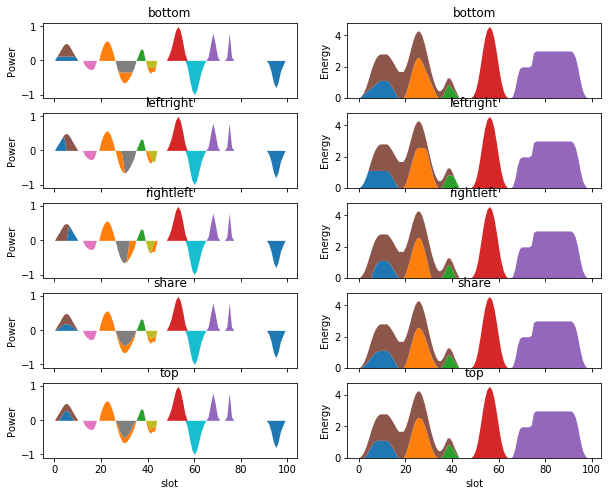

In [8]:
# Add efficiencies to compensate for round trip losses
dfplot = df_full_all.join(df_step_evts_all.set_index(['nevent', 'kind'])['eff'], on=['nevent', 'kind'])

dfplot = dfplot.assign(Charging=dfplot.ichg / dfplot.eff, Discharging=-dfplot.idch * dfplot.eff)
dfplot = dfplot.set_index(['kind', 'nevent', 't'])
dfplot['Stored energy'] = dfplot.groupby(level=['kind', 'nevent']).apply(lambda x: (x.Charging + x.Discharging).cumsum().reset_index([0, 1], drop=True))
dfplot = dfplot.sort_index()
dfplot.loc[dfplot['Stored energy'].abs() < 1e-4, 'Stored energy'] = 0

dfplot = dfplot.pivot_table(index=['kind', 't'], columns=['iteration', 'nevent'], values=['Charging', 'Discharging', 'Stored energy'])

fig, axarr = plt.subplots(5, 2, sharex=True)
fig.set_size_inches(10, 8)
map_ax = [(0, ['Charging', 'Discharging'], 'Power'),
          (1, ['Stored energy'], 'Energy')]

for ax_x, cols, ylabel in map_ax:
    for ax_y, kind in enumerate(dfplot.index.get_level_values('kind').unique()):

        ax = axarr[ax_y, ax_x]
        dfplot.loc[kind][cols].plot.area(linewidth=0, ax=ax, stacked=True, legend=False)
        ax.set_ylabel(ylabel)
        ax.set_title(kind)

### Plots by iteration for all profile assignments.

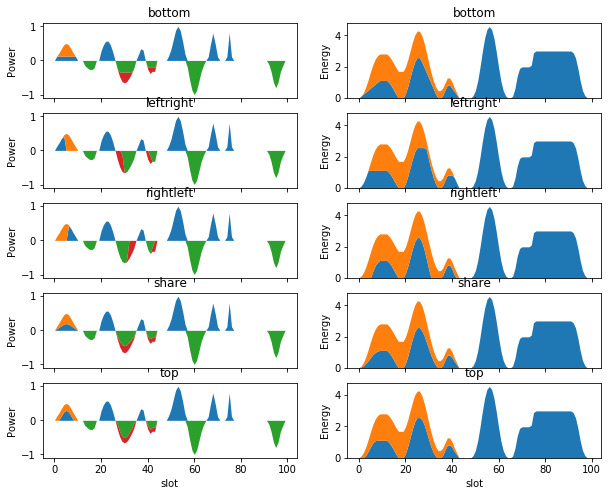

In [9]:
dfplot = dfplot.sum(level=[0, 'iteration'], axis=1)
fig, axarr = plt.subplots(5, 2, sharex=True)
fig.set_size_inches(10, 8)
map_ax = [(0, ['Charging', 'Discharging'], 'Power'),
          (1, ['Stored energy'], 'Energy')]

for ax_x, cols, ylabel in map_ax:
    for ax_y, kind in enumerate(dfplot.index.get_level_values('kind').unique()):

        ax = axarr[ax_y, ax_x]
        dfplot.loc[kind][cols].plot.area(linewidth=0, ax=ax, stacked=True, legend=False)
        ax.set_ylabel(ylabel)
        ax.set_title(kind)